# Regularized Logistic Regression: Microchip Quality Classification
Classifies microchips as accepted (1) or rejected (0) using two test scores. Demonstrates logistic regression from scratch with:
- Data loading and visualization
- Polynomial feature mapping (degree 6) to create non-linear decision boundary
- Sigmoid, unregularized and L2-regularized cost and gradient
- Gradient descent optimization
- Decision boundary plot
- Prediction function and training accuracy
Goal: show how regularization and feature expansion improve separability versus a simple linear boundary.

Data shapes: (118, 2) (118,)


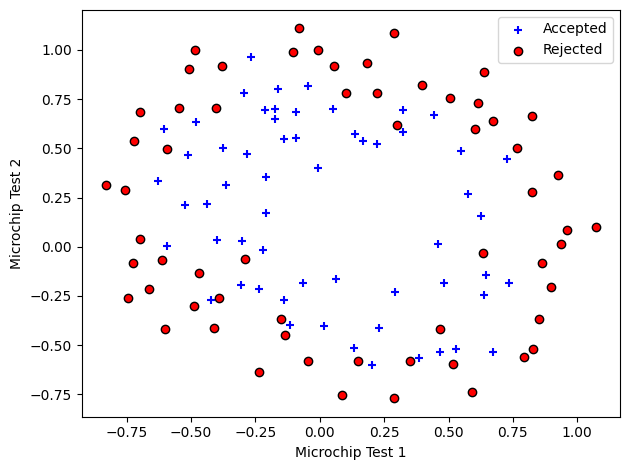

Original shape: (118, 2)
Mapped shape: (118, 27)
First original point: [0.051267 0.69956 ]
First mapped point: [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]
Iteration     0: Cost 0.7210
Iteration  1000: Cost 0.5875
Iteration  2000: Cost 0.5571
Iteration  3000: Cost 0.5332
Iteration  4000: Cost 0.5137
Iteration  5000: Cost 0.4975
Iteration  6000: Cost 0.4838
Iteration  7000: Cost 0.4721
Iteration  8000: Cost 0.4620
Iteration  9000: Cost 0.4531
Iteration  9999: Cost 0.4453


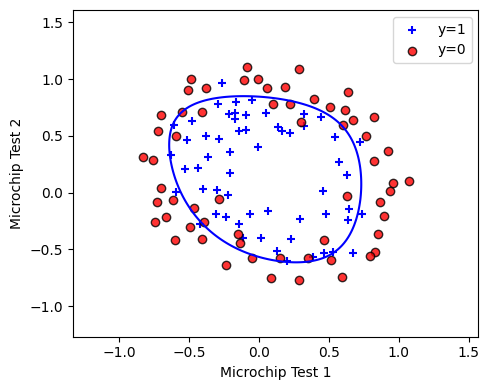

Train Accuracy: 82.20%


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --------------------------------------------------
# Data loading
# --------------------------------------------------
def load_data(path):
    """
    Reads comma-separated file: feature columns then label column.
    """
    data = np.loadtxt(path, delimiter=",")
    X = data[:, :-1]
    y = data[:, -1]
    return X, y

X_train, y_train = load_data("ex1data3.txt")
print("Data shapes:", X_train.shape, y_train.shape)

# --------------------------------------------------
# Plot raw data
# --------------------------------------------------
def plot_data(X, y, pos_label="Accepted", neg_label="Rejected"):
    pos = y == 1
    neg = y == 0
    plt.scatter(X[pos, 0], X[pos, 1], c='b', marker='+', label=pos_label)
    plt.scatter(X[neg, 0], X[neg, 1], c='r', marker='o', edgecolor='k', label=neg_label)

plt.figure()
plot_data(X_train, y_train)
plt.ylabel('Microchip Test 2')
plt.xlabel('Microchip Test 1')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Feature mapping
# --------------------------------------------------
def map_feature(x1, x2, degree=6):
    """
    Map two input features to polynomial features up to given degree.
    For degree=6 returns 27 features:
    [x1, x2, x1^2, x1 x2, x2^2, x1^3, ..., x1 x2^5, x2^6]
    """
    x1 = np.asarray(x1).ravel()
    x2 = np.asarray(x2).ravel()
    if x1.shape != x2.shape:
        raise ValueError("x1 and x2 must have the same shape")
    feats = []
    for i in range(1, degree + 1):
        for j in range(i + 1):
            feats.append((x1 ** (i - j)) * (x2 ** j))
    return np.stack(feats, axis=1)

print("Original shape:", X_train.shape)
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
print("Mapped shape:", X_mapped.shape)
print("First original point:", X_train[0])
print("First mapped point:", X_mapped[0])

# --------------------------------------------------
# Sigmoid
# --------------------------------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# --------------------------------------------------
# Cost (unregularized)
# --------------------------------------------------
def compute_cost(X, y, w, b, lambda_=None):
    m, n = X.shape
    cost = 0.0
    for i in range(m):
        z = np.dot(X[i], w) + b
        f = sigmoid(z)
        cost += -y[i] * np.log(f) - (1 - y[i]) * np.log(1 - f)
    return cost / m

# --------------------------------------------------
# Regularized cost
# --------------------------------------------------
def compute_cost_reg(X, y, w, b, lambda_=1.0):
    m, n = X.shape
    base = compute_cost(X, y, w, b)
    reg = np.sum(w ** 2)
    return base + (lambda_ / (2 * m)) * reg

# --------------------------------------------------
# Gradient (unregularized)
# --------------------------------------------------
def compute_gradient(X, y, w, b, lambda_=None):
    m, n = X.shape
    dj_dw = np.zeros_like(w)
    dj_db = 0.0
    for i in range(m):
        f = sigmoid(np.dot(X[i], w) + b)
        err = f - y[i]
        dj_dw += err * X[i]
        dj_db += err
    dj_dw /= m
    dj_db /= m
    return dj_db, dj_dw

# --------------------------------------------------
# Regularized gradient
# --------------------------------------------------
def compute_gradient_reg(X, y, w, b, lambda_=1.0):
    dj_db, dj_dw = compute_gradient(X, y, w, b)
    m = X.shape[0]
    dj_dw += (lambda_ / m) * w
    return dj_db, dj_dw

# --------------------------------------------------
# Gradient Descent
# --------------------------------------------------
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function,
                     alpha, num_iters, lambda_):
    J_history = []
    w_history = []
    w = w_in.copy()
    b = b_in
    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w, b, lambda_)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        if i < 100000:
            J_history.append(cost_function(X, y, w, b, lambda_))
        if i % math.ceil(num_iters / 10) == 0 or i == num_iters - 1:
            w_history.append(w.copy())
            print(f"Iteration {i:5d}: Cost {J_history[-1]:.4f}")
    return w, b, J_history, w_history

# --------------------------------------------------
# Train model
# --------------------------------------------------
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 1.0
lambda_ = 0.01
iterations = 10000
alpha = 0.01

w, b, J_history, _ = gradient_descent(
    X_mapped, y_train, initial_w, initial_b,
    compute_cost_reg, compute_gradient_reg,
    alpha, iterations, lambda_
)

# --------------------------------------------------
# Prepare decision boundary grid (separate step)
# --------------------------------------------------
def decision_boundary_grid(w, b, X_orig, degree=6, resolution=200):
    x1_min, x1_max = X_orig[:, 0].min() - 0.5, X_orig[:, 0].max() + 0.5
    x2_min, x2_max = X_orig[:, 1].min() - 0.5, X_orig[:, 1].max() + 0.5
    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, resolution),
        np.linspace(x2_min, x2_max, resolution)
    )
    grid_mapped = map_feature(xx1.ravel(), xx2.ravel(), degree)
    Z = sigmoid(grid_mapped @ w + b).reshape(xx1.shape)
    return xx1, xx2, Z

xx1, xx2, Z = decision_boundary_grid(w, b, X_train, degree=6)

# --------------------------------------------------
# Plot decision boundary (separate step)
# --------------------------------------------------
plt.figure(figsize=(5, 4))
pos = y_train == 1
neg = y_train == 0
plt.scatter(X_train[pos, 0], X_train[pos, 1], c='b', marker='+', label='y=1')
plt.scatter(X_train[neg, 0], X_train[neg, 1], c='r', marker='o', edgecolor='k', alpha=0.8, label='y=0')
cs = plt.contour(xx1, xx2, Z, levels=[0.5], colors=['blue'])

plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Prediction
# --------------------------------------------------
def predict(X, w, b):
    z = X @ w + b
    probs = sigmoid(z)
    return (probs >= 0.5).astype(int)

p = predict(X_mapped, w, b)
print("Train Accuracy: %.2f%%" % (np.mean(p == y_train) * 100.0))

## Summary & Reader Guide
You saw a full manual implementation of regularized logistic regression with polynomial feature mapping producing a curved decision boundary. Training accuracy is reported after convergence.

How to use:
1. Ensure ex1data3.txt is in the working directory.
2. Run cells top to bottom.
3. Adjust lambda_ and degree to see boundary changes.